In [1]:
#install the necessary dependencies by uncommenting and running the following commands:
#!wget https://raw.githubusercontent.com/bespoke-inc/bespoke-public-talks/2020/2020-10-31-ScipyJapan-Regex-to-DL/requirements.txt
#!pip install -r requirements.txt

### Task #1: Create a corpus

The first task will be making your own training data based on the above format. We will work a small dataset that we've provided and later some publicly available ones but participants are expected to create their own for this part of the workshop

## Training Data
This is a sample format of the training data we want to use:

```
training_phrases = {
        'when_is_check_in' : ['when is check-in','When can I check in?','when's checkin'],
        'where_is_the_front_desk' : ['Where is the front desk?','what is the location of the front desk?'...]}
}

answers : {
        'when_is_check_in' : 'Check in is at 3pm! :)',
        'where_is_the_front_desk' : 'The front desk is located on the 2nd floor.'}
```

In [1]:
import pandas as pd
import json

In [2]:
#get sample training data
!wget https://raw.githubusercontent.com/bespoke-inc/bespoke-public-talks/master/2020/2020-08-22-MLT-Rules-to-DL/training_sample.json

--2020-10-30 11:59:31--  https://raw.githubusercontent.com/bespoke-inc/bespoke-public-talks/master/2020/2020-08-22-MLT-Rules-to-DL/training_sample.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16736 (16K) [text/plain]
Saving to: ‘training_sample.json’

training_sample.jso 100%[===================>]  16.34K  --.-KB/s    in 0.02s   

2020-10-30 11:59:31 (821 KB/s) - ‘training_sample.json’ saved [16736/16736]



In [3]:
training_data = json.load(open('./training_sample.json','r'))

In [4]:
list(training_data.keys())

['hotel.when_is_check_in',
 'hotel.when_is_check_out',
 'hotel.is_there_early_check_in',
 'hotel.is_there_late_check_out',
 'hotel.where_is_the_front_desk_located']

In [5]:
answers = {
    'hotel.when_is_check_in': 'Check in is at 3pm!',
    'hotel.when_is_check_out': 'Check out is at 10am!',
    'hotel.is_there_late_check_out': 'For early check-out or late check-in please schedule beforehand',
    'hotel.is_there_early_check_in': 'For early check-out or late check-in please schedule beforehand',
    'hotel.where_is_the_front_desk_located': 'Front desk is located on the 2nd floor'
    }

In [6]:
import re

In [7]:
punct_re_escape = re.compile('[%s]' % re.escape('!"#$%&()*+,./:;<=>?@[\\]^_`{|}~'))

class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                p = self.remove_punctuation(p)
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [8]:
chatbot_data = MyChatbotData(training_data, 'patterns', answers)

In [9]:
chatbot_data.show_batch(10)

,intent,phrase,answer
0,hotel.when_is_check_in,when is check-in,Check in is at 3pm!
1,hotel.when_is_check_in,how to check in,Check in is at 3pm!
2,hotel.when_is_check_in,what time is the latest we can check into the ...,Check in is at 3pm!
3,hotel.when_is_check_in,what time is check in open till,Check in is at 3pm!
4,hotel.when_is_check_in,can you advise the check in time,Check in is at 3pm!
5,hotel.when_is_check_in,what time is check in for new hotel otani toky...,Check in is at 3pm!
6,hotel.when_is_check_in,late check in,Check in is at 3pm!
7,hotel.when_is_check_in,can i check in late,Check in is at 3pm!
8,hotel.when_is_check_in,what about check in,Check in is at 3pm!
9,hotel.when_is_check_in,im down to check in,Check in is at 3pm!


In [10]:
len(chatbot_data)

368

## Rule-based intent ~~classification~~ matching

The simplest approach to find if an query falls into a certain intent is to do some string comparison with our dataset. 

In [11]:
UNK = "I don't know"

In [12]:
def exact_match(query):
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        if query in phrases:
            return chatbot_data.get_answer(i)
    return UNK

In [13]:
exact_match("is there early check-in")

'For early check-out or late check-in please schedule beforehand'

In [14]:
exact_match("when do i check in")

'Check in is at 3pm!'

In [15]:
exact_match("can i check-in earlier than 12pm")

"I don't know"

## Preprocessing

- CJK
- normalize contractions
- remove hyphens
- remove stopwords
- check for typos
- normalize plurals
- normalize ascii
- normalize emojis
- remove punctuation



In [16]:
import re

EMOJIS = [[':)', '😀'],[';)', '😉'],[':(', '😞'],[';((', '😢'],[':p', '😛']]
_emoji_re = '[\U00010000-\U0010ffff]+'
emoji_re = re.compile(_emoji_re, flags=re.UNICODE)

def emoji_normalize(text):
    for e1, e2 in EMOJIS:
        text = text.replace(e1, e2)
    return text

def is_emoji(text):
    emoji = "".join(re.findall(_emoji_re, text))
    return emoji == text

def emoji_isolate(text):
    EMJ = "__EMOJI__"
    emoji_list = re.findall(_emoji_re, text)
    text = emoji_re.sub(f" {EMJ} ", text)
    new_str, ctr = [], 0
    for tok in text.split():
        if tok == EMJ:
            new_str.append(emoji_list[ctr])
            ctr += 1
        else:
            new_str.append(tok)
    return " ".join(new_str).strip()

In [17]:
import unicodedata

def ascii_normalize(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8") 

In [18]:
punct_re_escape = re.compile('[%s]' % re.escape('!"#$%&()*+,./:;<=>?@[\\]^_`{|}~'))

def remove_punctuation(text):
    punct_re_escape.sub('', text)

In [19]:
def preprocess(text):
    text = ascii_normalize(text) or text
    text = emoji_normalize(text) or text
    text = emoji_isolate(text) or text
    text = remove_punctuation(text) or text
    return text

### Partial String Matching
Instead of checking is the entire query string exists in our dataset, we try to find a partial match
and pick the intent that matches most closely. We will try to do this with using Levenshtein Distance 
to calculate the differences between sequences. The library [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy)
can help us do this

In [22]:
!pip install fuzzywuzzy

You should consider upgrading via the '/Users/asirsaeed/projects/dev/bin/python -m pip install --upgrade pip' command.


In [23]:
from fuzzywuzzy import process

In [24]:
def fuzzy_matching(query):
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        match, score = process.extractOne(query, phrases)
        if score > 90:
            return chatbot_data.get_answer(i)
    return UNK

In [25]:
fuzzy_matching("when do i check-in")

'Check in is at 3pm!'

In [26]:
fuzzy_matching("can i check-in earlier than 12pm")

'For early check-out or late check-in please schedule beforehand'

In [27]:
fuzzy_matching("what time is early check-in")

'Check in is at 3pm!'

## ML Classification
We will now add a probabilistic classifier to our set of methods to get better intent classification.
The algorithm we will use is [naive bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)

Naive Bayes classifiers works quite well for small amount of training data.

### Tokenizer
Before we feed it to our model for training we need to tokenize our training instances

In [28]:
import spacy

In [29]:
nlp = spacy.load('en_core_web_sm',parse=False,tagger=False)

In [30]:
doc = nlp("when can i check in?")
[tok.text for tok in doc]

['when', 'can', 'i', 'check', 'in', '?']

In [31]:
doc = nlp("when can i check-in?")
[tok.text for tok in doc]

['when', 'can', 'i', 'check', '-', 'in', '?']

In [32]:
doc = nlp("i didn't")
[tok.text for tok in doc]

['i', 'did', "n't"]

In [33]:
doc = nlp("thank you ありがとう")
[tok.text for tok in doc]

['thank', 'you', 'ありがとう']

In [34]:
doc = nlp("didn't    couldn't   ")
[tok.text for tok in doc if tok.text.strip()]

['did', "n't", 'could', "n't"]

In [35]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asirsaeed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [37]:
def tokenize_nd_join(text):
    doc = nlp(text.lower())
    return " ".join(tok.text for tok in doc if tok.text.strip() not in stopwords)

In [38]:
def get_xs_ys(train_data):
    x, y = [], []
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        x += [tokenize_nd_join(phrase) for phrase in phrases]
        y += [i]*len(phrases)
    return x, y

In [39]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [40]:
def train(x,y):
    vect = CountVectorizer(ngram_range=(1,2),max_features=None)
    nb = Pipeline([('vect',vect),('clf',ComplementNB(alpha=1.0,norm=False))])
    nb.fit(x,y)
    return nb

In [41]:
x, y = get_xs_ys(training_data)
nb_model = train(x, y)

In [42]:
def nb_pred(query):
    tokenized_query = tokenize_nd_join(query)
    pred = nb_model.predict([tokenized_query])[0]
    return chatbot_data.get_answer(pred)

In [43]:
nb_pred("what time is early check-in")

'For early check-out or late check-in please schedule beforehand'

In [44]:
import numpy as np

In [45]:
def nb_pred_top3(query):
    tokenized_query = tokenize_nd_join(query)
    pred_prob = nb_model.predict_proba([tokenized_query])
    preds_sorted = np.argsort(pred_prob)
    top3 = preds_sorted[:,-1],preds_sorted[:,-2],preds_sorted[:,-2]
    if pred_prob[0,top3[0]] > (pred_prob[0,top3[1]] + pred_prob[0,top3[2]]):
        pred = nb_model.named_steps['clf'].classes_[top3[0]][0]
        return chatbot_data.get_answer(pred)
    return UNK
    

In [46]:
nb_pred_top3("is there early check-in")

'For early check-out or late check-in please schedule beforehand'

## Intent Classification Pipeline

In [47]:
def get_pred(query):
    query = query.lower()
    pred = exact_match(query)
    if pred == UNK: pred = exact_match(preprocess(query))
    if pred == UNK: pred = nb_pred_top3(query)
    if pred == UNK: pred = nb_pred_top3(preprocess(query))
    if pred == UNK: pred = fuzzy_matching(query)
    if pred == UNK: pred = fuzzy_matching(preprocess(query))
    return pred

In [48]:
get_pred("when is check-in")

'Check in is at 3pm!'

In [49]:
get_pred("can i check-out late?")

'For early check-out or late check-in please schedule beforehand'

In [50]:
get_pred("where can i find the front desk?")

'Front desk is located on the 2nd floor'

### Moving ML to DL
We see that this pipeline using some rules and a probabilistic model are working quite well.
However, it doesn't scale with data and requires adding a lot of preprocessing and nuances to get working properly

Pros:
- There are noticeable improvement in using NNs over the current probabilistic model.
- Model can scale with data i.e it can improve as we add more annotated training data
- This can be a good point to move to NNs, since we are reaching the limits of rule based systems e.g fewer engineered features
- Simplified pipeline

Cons:
- Huge gains cannot be seen until the data is cleaned. 
- In its current state, the model will either be the same or slightly better than the current approach.
- Infrastructure changes

## Classification with Distil Bert

In [51]:
from fastai import *
from fastai.text import *

In [52]:
answers = {
    'hotel.when_is_check_in': 'Check in is at 3pm!',
    'hotel.when_is_check_out': 'Check out is at 10am!',
    'hotel.is_there_late_check_out': 'For early check-out or late check-in please schedule beforehand',
    'hotel.is_there_early_check_in': 'For early check-out or late check-in please schedule beforehand',
    'hotel.where_is_the_front_desk_located': 'Front desk is located on the 2nd floor'
    }

In [53]:
class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                p = self.remove_punctuation(p)
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [54]:
training_data = json.load(open('./training_sample.json','r'))

In [55]:
list(training_data.keys())

['hotel.when_is_check_in',
 'hotel.when_is_check_out',
 'hotel.is_there_early_check_in',
 'hotel.is_there_late_check_out',
 'hotel.where_is_the_front_desk_located']

In [56]:
chatbot_data = MyChatbotData(training_data, 'patterns', answers)

In [57]:
df = chatbot_data.df
df.head()

,intent,phrase,answer
0,hotel.when_is_check_in,when is check-in,Check in is at 3pm!
1,hotel.when_is_check_in,how to check in,Check in is at 3pm!
2,hotel.when_is_check_in,what time is the latest we can check into the ...,Check in is at 3pm!
3,hotel.when_is_check_in,what time is check in open till,Check in is at 3pm!
4,hotel.when_is_check_in,can you advise the check in time,Check in is at 3pm!


In [58]:
len(set(df['intent'])), len(df)

(5, 368)

In [59]:
path = Path('./')

Adapting fastai code for training transformers was inspired from this [blog post](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2)

In [60]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import PreTrainedTokenizer

In [61]:
class TransformersBaseTokenizer(BaseTokenizer):
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = [CLS] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [SEP]
        return tokens

In [62]:
transformer_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [63]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [64]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [65]:
pad_idx = transformer_tokenizer.pad_token_id

databunch = (TextList.from_df(df, cols='phrase', processor=transformer_processor)
             .split_by_rand_pct()
             .label_from_df(cols= 'intent')
             .databunch(bs=64, pad_first=False, pad_idx=pad_idx))

In [66]:
class TransformerModel(nn.Module):
  
    def __init__(self, transformer):
        super(TransformerModel,self).__init__()
        self.transformer = transformer
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

In [67]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
config.num_labels = databunch.train_ds.c

distil_bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
transformer_model = TransformerModel(distil_bert)

In [68]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learn = Learner(databunch, transformer_model, opt_func = CustomAdamW, metrics=[accuracy])

In [69]:

list_layers = [learn.model.transformer.base_model.embeddings,
               learn.model.transformer.base_model.transformer.layer[0],
               learn.model.transformer.base_model.transformer.layer[1],
               learn.model.transformer.base_model.transformer.layer[2],
               learn.model.transformer.base_model.transformer.layer[3],
               learn.model.transformer.base_model.transformer.layer[4],
               learn.model.transformer.base_model.transformer.layer[5],
               learn.model.transformer.pre_classifier,
               learn.model.transformer.classifier]
               
learn.split(list_layers);

In [70]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


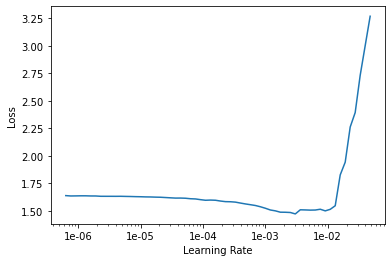

In [71]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [72]:
learn.fit_one_cycle(3,max_lr=1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.659371,1.850191,0.219178,00:02
1,1.582303,1.291429,0.438356,00:02
2,1.478284,1.276817,0.561644,00:02


In [73]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(8e-4/(2.6**4),8e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.359964,21.788212,0.232877,00:02
1,5.632231,2.840953,0.315068,00:02


In [74]:
learn.freeze_to(-5)
learn.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.328775,4.122964,0.219178,00:04
1,3.377215,1.870122,0.315068,00:04


In [75]:
learn.freeze_to(-8)
learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.787705,1.675999,0.082192,00:06
1,1.670295,1.274541,0.520548,00:06


In [76]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.350474,1.114394,0.520548,00:07
1,1.236143,0.773349,0.684932,00:07
2,1.115984,0.634548,0.808219,00:07
3,0.991540,0.543521,0.808219,00:08
4,0.896839,0.515857,0.849315,00:07


In [125]:
pred, _, probs = learn.predict("what time is check-in?")
print(learn.data.train_ds.y.classes[pred.data], probs)

hotel.is_there_late_check_out tensor([0.0371, 0.4484, 0.2567, 0.2468, 0.0111])


In [78]:
interp = TextClassificationInterpretation(learn,*learn.get_preds(with_loss=True))

In [79]:
interp.show_top_losses(20)

Text,Prediction,Actual,Loss,Probability
[CLS] can i check ##out late [SEP],hotel.is_there_early_check_in,hotel.is_there_late_check_out,4.09,0.00
[CLS] how to check in [SEP],hotel.where_is_the_front_desk_located,hotel.when_is_check_in,2.58,0.08
[CLS] when is the usual check - in time [SEP],hotel.is_there_late_check_out,hotel.when_is_check_in,1.39,0.25
[CLS] where can i find the front desk [SEP],hotel.is_there_late_check_out,hotel.where_is_the_front_desk_located,1.22,0.01
[CLS] may i check - out in advance [SEP],hotel.is_there_early_check_in,hotel.is_there_late_check_out,1.22,0.05
[CLS] when ' s check in [SEP],hotel.is_there_late_check_out,hotel.when_is_check_in,1.13,0.32
[CLS] check out [SEP],hotel.is_there_early_check_in,hotel.when_is_check_out,1.10,0.01
[CLS] will i be charged for late check out [SEP],hotel.is_there_late_check_out,hotel.is_there_late_check_out,1.08,0.42
[CLS] i ' ll be arriving after 11 ##pm [SEP],hotel.is_there_late_check_out,hotel.when_is_check_in,1.02,0.36
[CLS] when can i check - in [SEP],hotel.is_there_late_check_out,hotel.when_is_check_in,0.98,0.27


### Using Named Entity Recognition to extract parameters
Generalizing your training data with entity classes
Add named entities to one intent and use spaCy to extract

In [80]:
class ParameterModel():
    
    def __init__(self, param_list):
        self.parameters = param_list
        self.label_ = 'PARAM'
    
    def replace_entities(self, text):
        """Replace entities in the text with their respective labels"""
        entity_replaced_text = text
        for p in self.parameters:
            if p in text:
                entity_replaced_text = text.replace(p, f'<__{self.label_}__>')
        return entity_replaced_text

In [81]:
food_list = ['japanese','indian','thai','chinese','fast food','bbq','cafe']
food_param_model = ParameterModel(food_list) 

In [82]:
food_param_model.replace_entities("I want fast food")

'I want <__PARAM__>'

In [85]:
MODEL_NAME = 'en_core_web_sm'

class SpacyModel(object):
    spacy_model = None  # Where we keep the model when it's loaded

    @classmethod
    def get_base_spacy_model(cls):
        """Get the base spacy model"""
        if not cls.spacy_model:
            cls.spacy_model = spacy.load(MODEL_NAME)
        return cls.spacy_model
    
    @classmethod
    def replace_entities(cls, text):
        """Replace entities in the text with their respective labels"""
        spacy_model = cls.get_base_spacy_model()
        doc = spacy_model(text)
        entity_replaced_text = text
        for e in reversed(doc.ents):
            start = e.start_char
            end = start + len(e.text)
            entity_replaced_text = entity_replaced_text[:start] + f'<__{e.label_}__>' + entity_replaced_text[end:]
        return entity_replaced_text

In [88]:
SpacyModel.replace_entities("how do i get to tokyo")

'how do i get to <__GPE__>'

In [89]:
SpacyModel.replace_entities("can i get a reservation for Sunday")

'can i get a reservation for <__DATE__>'

### Using users to disambiguate intents
When two intents are good candidates for the user's text, instead of picking the best, ask the user which they meant.
Add disambiguation ability in your bot

### Typos
Since users are typing in their text, errors are common. Hence, the bot must be resilient to typos
Add typo correction in your bot

## Putting it all together

In [90]:
def replace_entities(text):
    entity_replaced = SpacyModel.replace_entities(text)
    entity_replaced = food_param_model.replace_entities(entity_replaced)
    return entity_replaced

In [91]:
class TextFactory:

    def __init__(self, text):
        self.raw = text
        self._sanitized = None
        self._entity_replaced = None
        self._sanitized_and_entity_replaced = None

    def sanitized(self):
        if not self._sanitized:
            self._sanitized = preprocess(self.raw)
        return self._sanitized
    
    def entity_replaced(self):
        if not self._entity_replaced:
            self._entity_replaced = replace_entities(self.raw)
        return self._entity_replaced

    def typo_corrected(self):
        #if not self._typo_corrected:
        #    self._typo_corrected = typo_correct(self.raw)
        #return self._typo_corrected
        pass

    def sanitized_and_entity_replaced(self):
        if not self._sanitized_and_entity_replaced:
            self._sanitized_and_entity_replaced = replace_entities(self.sanitized())
        return self._sanitized_and_typo_corrected

In [92]:
class ClassifierBuilder:

    def __init__(self, query):
        self.raw_query = query
        self.queries = []
        self.classifiers = []
    
    def add_classifiers_query(self, classifier, query):
        self.classifiers.append(classifier)
        self.queries.append(query)
        return self
    
    def build(self):
        # validation
        if not self.classifiers:
            raise Exception('Must specify classifiers')
        # build
        preds = None
        for c in self.classifiers:
            pred = c.predict(self.raw_query)
            if pred != UNK:
                return pred
        return pred

In [93]:
class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [94]:
class ExactMatch:
    
    def __init__(self, data):
        self.data = data

    def predict(self, query):
        intents = self.data.get_intents()
        for i in intents:
            phrases = self.data.get_phrases(i)
            if query in phrases:
                return i
        return UNK

In [95]:
class FuzzyMatch:

    def __init__(self, data):
        self.data = data
    
    def predict(self, query):
        intents = self.data.get_intents()
        for i in intents:
            phrases = self.data.get_phrases(i)
            match, score = process.extractOne(query, phrases)
            if score > 90:
                return chatbot_data.get_answer(i)
        return UNK

In [96]:
class NaiveBayesMatch:
    
    def __init__(self, data, model):
        self.data = data
        self.nb_model = model
        
    def predict(self, query):
        tokenized_query = tokenize_nd_join(query)
        pred_prob = nb_model.predict_proba([tokenized_query])
        preds_sorted = np.argsort(pred_prob)
        top3 = preds_sorted[:,-1],preds_sorted[:,-2],preds_sorted[:,-2]
        if pred_prob[0,top3[0]] > (pred_prob[0,top3[1]] + pred_prob[0,top3[2]]):
            pred = nb_model.named_steps['clf'].classes_[top3[0]][0]
        return pred

In [126]:
class DistilBertMatch:
    def __init__(self, data, learner):
        self.data = data
        self.learner = learner
    
    def predict(self, query):
        pred, idx, probs = self.learner.predict(query)
        return learn.data.train_ds.y.classes[pred.data]

In [98]:
exact_match_classifier = ExactMatch(chatbot_data)
fuzzy_match_classifier = FuzzyMatch(chatbot_data)
naive_bayes_classifier = NaiveBayesMatch(chatbot_data, nb_model)
distil_bert_classifier = DistilBertMatch(chatbot_data, learn)

In [99]:
class Predictor:
    def __init__(self, query):
        self.text_factory = TextFactory(query)
        self.pipeline = ClassifierBuilder(query)

    def predict(self):
        pred = self.pipeline.add_classifiers_query(exact_match_classifier, self.text_factory.raw) \
                            .add_classifiers_query(exact_match_classifier, self.text_factory.sanitized()) \
                            .add_classifiers_query(exact_match_classifier, self.text_factory.entity_replaced()) \
                            .add_classifiers_query(distil_bert_classifier, self.text_factory.raw) \
                            .add_classifiers_query(distil_bert_classifier, self.text_factory.sanitized()) \
                            .add_classifiers_query(distil_bert_classifier, self.text_factory.entity_replaced()) \
                            .add_classifiers_query(fuzzy_match_classifier, self.text_factory.raw) \
                            .build()
        return pred

In [100]:
predictor = Predictor("what time is check-in")
predictor.predict()

'hotel.when_is_check_in'

## Metrics

In [110]:
from sklearn.model_selection import train_test_split

class MyChatbotData:
    
    def __init__(self, json_obj, text_fld):
        xs, ys, ans = [], [], []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            xs += [p.lower() for p in patterns]
            ys += [intent]* len(patterns)

        (train_x, train_y), (test_x, test_y) = MyChatbotData.make_train_test_split(xs, ys)
        self.train_df = pd.DataFrame(np.stack((train_x, train_y),axis=1), columns=['phrase','intent'])
        self.test_df = pd.DataFrame(np.stack((test_x, test_y),axis=1), columns=['phrase','intent'])
    
    @staticmethod
    def make_train_test_split(xs, ys):
        X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=42)
        return (X_train, y_train), (X_test, y_test)
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.train_df[self.train_df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.train_df['intent']))
    
    def show_batch(self, size=5):
        return self.train_df.head(size)

In [111]:
chatbot_data = MyChatbotData(training_data, 'patterns')

In [112]:
test_set = chatbot_data.test_df
test_set.head()

,phrase,intent
0,check in early,hotel.is_there_early_check_in
1,required check in time,hotel.when_is_check_in
2,can i late check in,hotel.when_is_check_in
3,where’s the concierge,hotel.where_is_the_front_desk_located
4,what time is checkin,hotel.when_is_check_in


In [127]:
exact_match_classifier = ExactMatch(chatbot_data)
fuzzy_match_classifier = FuzzyMatch(chatbot_data)
naive_bayes_classifier = NaiveBayesMatch(chatbot_data, nb_model)
distil_bert_classifier = DistilBertMatch(chatbot_data, learn)

In [128]:
from sklearn.metrics import precision_recall_fscore_support

In [129]:
preds, labels = [], list(test_set['intent'])
for i in range(len(test_set)):
    predictor = Predictor(test_set.iloc[i]['phrase'])
    preds.append(predictor.predict())

In [130]:
precision_recall_fscore_support(labels, preds, average='weighted')

(0.8720077220077219, 0.7837837837837838, 0.7561151245361771, None)